### Clustering

In [49]:
import re
import random
import spacy
import numpy as np
import itertools
import collections
import functools
import operator
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

Load data

In [50]:
def load_data(path):
    func_names = []
    func_types = []
    with open(path, "r") as file:
        for name, *types in map(lambda x: x.strip().split(","), file.readlines()):
            func_types.append(types)
            func_names.append(name)
    return func_names, func_types

def printk(funcs, k=10, show_sort=True, nmap=None, rand=False):
    print(f"#funcs={len(funcs)}\nfuncs:")
    indices = random.choices(range(len(funcs)), k=k) if rand else range(k)
    print(*((funcs[i], nmap[funcs[i]]) if nmap else funcs[i] for i in indices), sep='\n')
    if show_sort:
        print("\nsorted:", *((f, nmap[f]) if nmap else f for f, _ in zip(sorted(funcs), range(k))), sep='\n')

func_names, func_types = load_data("functions.txt")
printk(func_names)

#funcs=71779
funcs:
doRead
js_cocos2dx_studio_EventFrame_init
VPU_DecOpen
parseusername
vreinterpretq_s16_s8
HAL_SndCard_PcmRead
drv_mag_st_lsm303agr_selftest
sk_SSL_CIPHER_new_reserve
FMC_GetChkSum
spvc_compiler_set_member_name

sorted:
AACQuantize
AACQuantizeEnd
AACQuantizeInit
ABSL_DECLARE_FLAG
ABSL_DECLARE_FLAG
ABSL_DECLARE_FLAG
ABSL_DECLARE_FLAG
ABSL_DECLARE_FLAG
ABSL_DECLARE_FLAG
ABSL_DECLARE_FLAG


Drop wrong names

In [51]:
def drop_wrong_names(func_names, func_types):
    re_ident = re.compile(rf"^[a-zA-Z_][a-zA-Z_0-9]*$", re.UNICODE)
    func_names, func_types = map(list, zip(*(itertools.filterfalse(lambda x: not re_ident.fullmatch(x[0]),
                                                                 zip(func_names, func_types)))))
    return func_names, func_types

func_names, func_types = drop_wrong_names(func_names, func_types)
printk(func_names)

#funcs=71668
funcs:
doRead
js_cocos2dx_studio_EventFrame_init
VPU_DecOpen
parseusername
vreinterpretq_s16_s8
HAL_SndCard_PcmRead
drv_mag_st_lsm303agr_selftest
sk_SSL_CIPHER_new_reserve
FMC_GetChkSum
spvc_compiler_set_member_name

sorted:
AACQuantize
AACQuantizeEnd
AACQuantizeInit
ABSL_DECLARE_FLAG
ABSL_DECLARE_FLAG
ABSL_DECLARE_FLAG
ABSL_DECLARE_FLAG
ABSL_DECLARE_FLAG
ABSL_DECLARE_FLAG
ABSL_DECLARE_FLAG


Split names to tokens

In [52]:
def tokenize_funcs(funcs):
    oneword = re.compile(r"^[a-z][a-z0-9]+|[A-Z][A-Z0-9]$")
    difCase = re.compile(r".+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)")
    under_scores_split = re.compile(r"_")

    tokenized_funcs = []
    for f in funcs:
        if oneword.fullmatch(f):
            tokenized_funcs.append([f])
        elif "_" in f:
            tokenized_funcs.append([w for w in under_scores_split.split(f) if w])
        else:
            tokenized_funcs.append([w.group(0) for w in difCase.finditer(f) if w.group(0)])
    return tokenized_funcs

tokenized_func_names = tokenize_funcs(func_names)
name2tokens = {f: tokenized_func_names[i] for i, f in enumerate(func_names)}
printk(func_names, nmap=name2tokens, rand=True)
del name2tokens

#funcs=71668
funcs:
('acl_pthread_pool_idle', ['acl', 'pthread', 'pool', 'idle'])
('efpg_write_mac', ['efpg', 'write', 'mac'])
('CyDmaSetTriggerType', ['Cy', 'Dma', 'Set', 'Trigger', 'Type'])
('acl_xml2_create_node', ['acl', 'xml2', 'create', 'node'])
('lv_mem_init', ['lv', 'mem', 'init'])
('Custom_GetRxRequest', ['Custom', 'GetRxRequest'])
('v4l1_init_window', ['v4l1', 'init', 'window'])
('RTC_WriteMonth', ['RTC', 'WriteMonth'])
('jffs2_vfs_statfs', ['jffs2', 'vfs', 'statfs'])
('EVP_PKEY_asn1_set_siginf', ['EVP', 'PKEY', 'asn1', 'set', 'siginf'])

sorted:
('AACQuantize', ['AAC', 'Quantize'])
('AACQuantizeEnd', ['AAC', 'Quantize', 'End'])
('AACQuantizeInit', ['AAC', 'Quantize', 'Init'])
('ABSL_DECLARE_FLAG', ['ABSL', 'DECLARE', 'FLAG'])
('ABSL_DECLARE_FLAG', ['ABSL', 'DECLARE', 'FLAG'])
('ABSL_DECLARE_FLAG', ['ABSL', 'DECLARE', 'FLAG'])
('ABSL_DECLARE_FLAG', ['ABSL', 'DECLARE', 'FLAG'])
('ABSL_DECLARE_FLAG', ['ABSL', 'DECLARE', 'FLAG'])
('ABSL_DECLARE_FLAG', ['ABSL', 'DECLARE', 'FLAG']

Drop digits from tokens, convert to low register

In [53]:
def drop_wrong_symbols(func_names, tokenized_func_names, func_types):
    # first approach to drop all digits, second only if > 50%
    wrong_char = re.compile(r"[\d]")
    tokenized_func_names_ = []
    func_types_ = []
    func_names_ = []
    for i, (name, tokenized_name, types) in enumerate(zip(func_names, tokenized_func_names, func_types)):
        processed_tokens = [re.sub(wrong_char, "", token).lower()
                            for token in tokenized_name if re.sub(wrong_char, "", token)]
        if processed_tokens:
            tokenized_func_names_.append(processed_tokens)
            func_types_.append(types)
            func_names_.append(name)

    return func_names_, tokenized_func_names_, func_types_

func_names, tokenized_func_names, func_types = drop_wrong_symbols(func_names, tokenized_func_names, func_types)
name2tokens = {f: tokenized_func_names[i] for i, f in enumerate(func_names)}
printk(func_names, nmap=name2tokens, rand=True)
del name2tokens

#funcs=71668
funcs:
('mipi_sensor_config', ['mipi', 'sensor', 'config'])
('getpriority', ['getpriority'])
('duk__comp_recursion_decrease', ['duk', 'comp', 'recursion', 'decrease'])
('TC_MPU_Load', ['tc', 'mpu', 'load'])
('conn_cache_push_stream', ['conn', 'cache', 'push', 'stream'])
('rwble_hl_init', ['rwble', 'hl', 'init'])
('acl_pthread_pool_destroy', ['acl', 'pthread', 'pool', 'destroy'])
('can_inline', ['can', 'inline'])
('BN_GF2m_poly2arr', ['bn', 'gfm', 'polyarr'])
('hal_dma_set_handler', ['hal', 'dma', 'set', 'handler'])

sorted:
('AACQuantize', ['aac', 'quantize'])
('AACQuantizeEnd', ['aac', 'quantize', 'end'])
('AACQuantizeInit', ['aac', 'quantize', 'init'])
('ABSL_DECLARE_FLAG', ['absl', 'declare', 'flag'])
('ABSL_DECLARE_FLAG', ['absl', 'declare', 'flag'])
('ABSL_DECLARE_FLAG', ['absl', 'declare', 'flag'])
('ABSL_DECLARE_FLAG', ['absl', 'declare', 'flag'])
('ABSL_DECLARE_FLAG', ['absl', 'declare', 'flag'])
('ABSL_DECLARE_FLAG', ['absl', 'declare', 'flag'])
('ABSL_DECLARE_FLA

Split concatenated words to separate tokens

In [54]:
def create_segment_func(tokenized_func_names, c=1, base=1/26, prior=1e-7):
    word2count = collections.Counter(itertools.chain(*tokenized_func_names))
    total_num_words = sum(word2count.values())
    corrected_total_num_words = (len(word2count) + 1) * c + total_num_words
    word2prob1 = {k: v / total_num_words for k, v in word2count.items()}
    word2prob2 = {k: (v + c) / corrected_total_num_words for k, v in word2count.items()}
    unseen_prob = c / corrected_total_num_words
    ones_length2count = collections.Counter(map(len, (word for word, count in word2count.items() if count == 1)))
    ones_longest = max(ones_length2count)
    ones_num_words = sum(ones_length2count.values())

    # naive probability v1
    def prob1(word):
        return word2prob1[word]

    # smoothed probability v1
    def prob2(word):
        return word2prob2[word] if word in word2prob2 else unseen_prob

    # smoothed probability v2
    def prob3(word):
        unseen_estimation = ones_length2count[len(word)] / ones_num_words if len(word) in ones_length2count \
            else ones_length2count[ones_longest] / ones_num_words * base ** (len(word) - ones_longest)
        return word2prob1[word] if word in word2prob1 else prior * unseen_estimation

    def split(word, start=1, end=20):
        return ((word[:i], word[i:]) for i in range(start, min(len(word) + 1, end)))

    @functools.lru_cache(maxsize=1000)
    def segment(word):
        if not word:
            return []
        candidates = ([first] + segment(remaining) for first, remaining in split(word))
        return max(candidates, key=lambda x: functools.reduce(operator.__mul__, map(prob3, x), 1))
    return segment

def segmentize_corpus(tokenized_func_names, segmenter):
    tokenized_func_names = [list(itertools.chain(*(segmenter(token) for token in tokens)))
                            for tokens in tokenized_func_names]
    return tokenized_func_names

segmenter = create_segment_func(tokenized_func_names)
words = ["ccfileutils", "setendframeindex", "inneractionframe", "setsearchresolutionsorder",
         "dynamicmeminit", "wakeupiodisableglobal", "getinit", "getinitz"]
print(*((word, segmenter(word)) for word in words), "", sep='\n')
tokenized_func_names = segmentize_corpus(tokenized_func_names, segmenter)

name2tokens = {f: tokenized_func_names[i] for i, f in enumerate(func_names)}
printk(func_names, nmap=name2tokens, rand=True)
del words, name2tokens

('ccfileutils', ['ccfileutils'])
('setendframeindex', ['setendframeindex'])
('inneractionframe', ['inneractionframe'])
('setsearchresolutionsorder', ['set', 'search', 'resolutionsorder'])
('dynamicmeminit', ['dynamicmeminit'])
('wakeupiodisableglobal', ['wakeupiodisable', 'global'])
('getinit', ['get', 'init'])
('getinitz', ['get', 'init', 'z'])

#funcs=71668
funcs:
('Timer_A_getEnabledInterruptStatus', ['timer', 'a', 'get', 'enabled', 'interrupt', 'status'])
('httpclient_retrieve_content', ['httpclient', 'retrieve', 'content'])
('ulocation_hal_init', ['ulocation', 'hal', 'init'])
('BBWriteTrampoline', ['bb', 'write', 'trampoline'])
('EC_KEY_set_enc_flags', ['ec', 'key', 'set', 'enc', 'flags'])
('_mm_rsqrt_ss', ['mm', 'rsqrt', 'ss'])
('getattrs', ['getattrs'])
('is_valid_tx_command', ['is', 'valid', 'tx', 'command'])
('js_cocos2dx_ui_Layout_setBackGroundColorOpacity', ['js', 'cocosdx', 'ui', 'layout', 'setbackgroundcolor', 'opacity'])
('mark_rm_sd', ['mark', 'rm', 'sd'])

sorted:
('AAC

Lemmatize tokens

In [55]:
print("#uniq tokens before lemmatizing", len(set(itertools.chain(*tokenized_func_names))), "\n")

def lemmatize_corpus(tokenized_func_names):
    nlp = spacy.load("en", disable=["parser", "ner"])
    lengths = np.cumsum([0] + list(map(len, tokenized_func_names)))
    flat_tokens = list(itertools.chain(*tokenized_func_names))
    doc = spacy.tokens.Doc(nlp.vocab, words=flat_tokens)
    tokenized_func_names = [[token.lemma_ for token in doc[lengths[i - 1]: lengths[i]]]
                            for i in range(1, len(tokenized_func_names) + 1)]
    return tokenized_func_names

tokenized_func_names = lemmatize_corpus(tokenized_func_names)
name2tokens = {f: tokenized_func_names[i] for i, f in enumerate(func_names)}
printk(func_names, nmap=name2tokens, rand=True)

print("\n#uniq tokens after lemmatizing", len(set(itertools.chain(*tokenized_func_names))), "\n")
del name2tokens

#uniq tokens before lemmatizing 18011 

#funcs=71668
funcs:
('strtogid', ['strtogid'])
('drv_acc_st_lsm303agr_st_discard', ['drv', 'acc', 'st', 'lsmagr', 'st', 'discard'])
('SDSPIMSP432_control', ['sdspimsp', 'control'])
('pbuf_header', ['pbuf', 'header'])
('PBEPARAM_new', ['pbeparam', 'new'])
('BTIMx_BTOCR_OUTSEL_Get', ['btimx', 'btocr', 'outsel', 'get'])
('wpas_mac_addr_rand_scan_clear', ['wpas', 'mac', 'addr', 'rand', 'scan', 'clear'])
('js_cocos2dx_ParticleMeteor_createWithTotalParticles', ['js', 'cocosdx', 'particlemeteor', 'create', 'withtotalparticles'])
('BalanceEnergy', ['balance', 'energy'])
('BSP_IntHandler_074', ['bsp', 'inthandler'])

sorted:
('AACQuantize', ['aac', 'quantize'])
('AACQuantizeEnd', ['aac', 'quantize', 'end'])
('AACQuantizeInit', ['aac', 'quantize', 'init'])
('ABSL_DECLARE_FLAG', ['absl', 'declare', 'flag'])
('ABSL_DECLARE_FLAG', ['absl', 'declare', 'flag'])
('ABSL_DECLARE_FLAG', ['absl', 'declare', 'flag'])
('ABSL_DECLARE_FLAG', ['absl', 'declare', 'flag'])

Drop rare tokens

dict size: 4037

dict:
('get', 5050)
('js', 4367)
('set', 4188)
('cocosdx', 3816)
('init', 3007)
('test', 1976)
('read', 1608)
('drv', 1529)
('acl', 1468)
('sk', 1306)

reversed dict:
('selftest', 5)
('terminal', 5)
('childrenwithcleanup', 5)
('readui', 5)
('creat', 5)
('ifkeep', 5)
('sticky', 5)
('kdf', 5)
('hxtal', 5)
('bandwidth', 5)


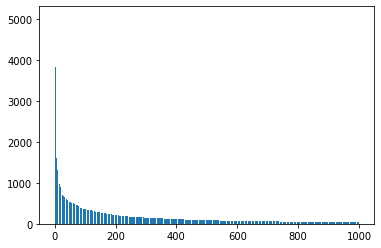

In [66]:
def prune_vocabulary(func_names, tokenized_func_names, func_types, min_ct=5):
    word2count = collections.Counter(itertools.chain(*tokenized_func_names))
    word2count = {k: v for k, v in sorted(word2count.items(), key=lambda item: item[1], reverse=True) if v >= min_ct}
    vocab_low_to_high = {k: v for k, v in sorted(word2count.items(), key=lambda item: item[1], reverse=False)}
    print(f"dict size: {len(word2count)}\n\ndict:")
    print(*((k, v) for _, (k, v) in zip(range(10), word2count.items())), "\nreversed dict:", sep='\n')
    print(*((k, v) for _, (k, v) in zip(range(10), vocab_low_to_high.items())), sep='\n')

    word2ind = {w: i for w, i in zip(word2count.keys(), itertools.count())}
    ind2count = {word2ind[w]: freq for (w, freq), _ in zip(word2count.items(), range(1000))}
    plt.bar(ind2count.keys(), ind2count.values())
    plt.show()

    tokenized_func_names_ = []
    func_types_ = []
    func_names_ = []
    for i, (name, tokenized_name, types) in enumerate(zip(func_names, tokenized_func_names, func_types)):
        processed_tokens = [token for token in tokenized_name if token in word2count]
        if processed_tokens:
            tokenized_func_names_.append(processed_tokens)
            func_types_.append(types)
            func_names_.append(name)

    return func_names_, tokenized_func_names_, func_types_

func_names, tokenized_func_names, func_types = prune_vocabulary(func_names, tokenized_func_names, func_types)

Process types

In [67]:
def tokenize_types(func_types):
    type_set = {
        "int", "unsigned int", "char", "unsigned char", "enum", "struct", "void", "long", "unsigned long",
        "float", "double", "short", "unsigned short", "bool", "union", "long long", "unsigned long long"}
    type_dict = {re.compile(t): t for t in type_set}
    r_drop = re.compile(r"\*|restrict|const")
    struct_type = re.compile("struct")
    tokenized_types = [[0 for _ in range(len(f_types))] for f_types in func_types]
    for i, f_types in enumerate(func_types):
        for j, type in enumerate(f_types):
            cleaned_type = re.sub(r_drop, "", type)
            for re_t, t in type_dict.items():
                if re.search(re_t, cleaned_type):
                    tokenized_types[i][j] = t
                    break
            else:
                tokenized_types[i][j] = type_dict[struct_type]
    return tokenized_types

print(*(func_types[i] for i in range(10)), sep='\n')
tokenized_types = tokenize_types(func_types)
print("\n", *(tokenized_types[i] for i in range(10)), sep='\n')

['long', 'int', 'unsigned long', 'void *', 'unsigned long']
['bool', 'int *', 'int', 'int *']
['int', 'int *', 'int *']
['short', 'signed char']
['int', 'int', 'int *', 'int']
['int', 'int *']
['struct stack_st_SSL_CIPHER *', 'int (*)(const struct ssl_cipher_st *const *', ' const struct ssl_cipher_st *const *)', 'int']
['int', 'int', 'int']
['void', 'int', 'int', 'unsigned int', 'const char *']
['int', 'const void *', 'int', 'int *']


['long', 'int', 'unsigned long', 'void', 'unsigned long']
['bool', 'int', 'int', 'int']
['int', 'int', 'int']
['short', 'char']
['int', 'int', 'int', 'int']
['int', 'int']
['struct', 'int', 'struct', 'int']
['int', 'int', 'int']
['void', 'int', 'int', 'int', 'char']
['int', 'void', 'int', 'int']


Construct feature matrix

In [68]:
tokenized_features = [tok_name + tok_types for tok_name, tok_types in zip(tokenized_func_names, tokenized_types)]
tfidf_matrix = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False, sublinear_tf=True)
tfidf_matrix = tfidf_matrix.fit_transform(tokenized_func_names)
print(tfidf_matrix.shape)

(69109, 4037)


Clustering

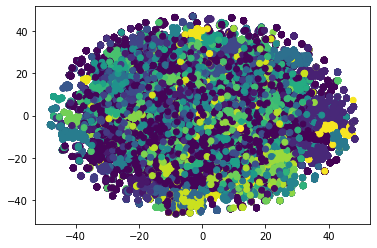

298.4031732082367


In [69]:
n_clusters=100
model = KMeans(n_clusters=n_clusters)
predictions = model.fit_predict(tfidf_matrix)
tsne = TSNE(learning_rate=100)
transformed = tsne.fit_transform(tfidf_matrix)
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]
plt.scatter(x_axis, y_axis, c=predictions)
plt.show()
del transformed, x_axis, y_axis

In [70]:
centers = np.array(model.cluster_centers_)
closest_ct = 10
for i in range(n_clusters):
    center = centers[i]
    cluster_indexes = [j for j, cl in enumerate(predictions) if cl == i]
    cluster_funcs = [func_names[j] for j in cluster_indexes]
    cluster_feats = tfidf_matrix[cluster_indexes, :]
    cluster_feats -= center
    cluster_feats = np.square(cluster_feats)
    cluster_feats = cluster_feats.sum(1)
    cluster_dists = np.asarray(np.sqrt(cluster_feats)).reshape(-1)
    cluster_closest_indexes = np.argpartition(cluster_dists, closest_ct)
    print(f"cluster{i + 1}")
    for j in range(closest_ct):
        print(cluster_funcs[cluster_closest_indexes[j]])
    print("")

cluster1
js_cocos2dx_ui_Widget_setSizePercent
js_cocos2dx_ui_Widget_getPositionType
js_cocos2dx_ui_Widget_getSizeType
js_cocos2dx_ui_Widget_isHighlighted
js_cocos2dx_ui_Widget_setHighlighted
js_cocos2dx_ui_Widget_isFocused
js_cocos2dx_ui_Widget_getLayoutSize
js_cocos2dx_ui_Widget_requestFocus
js_cocos2dx_ui_Widget_isBright
js_cocos2dx_ui_Widget_setFlippedX

cluster2
wire_to_event
wire_to_event
handle_reset
find_leftmost_to_line
gpio_event_output_disable
toKey
crc_data_register_reset
mevent_to_key
keycode_to_key
task_event_entry_register

cluster3
CoapObsServerAll_delete
__delete
delete
CoAPObsClient_delete
test_delete
test_delete
timer_delete
sk_X509_delete
sk_X509_delete_ptr
DeleteLinker

cluster4
MPL3115WriteBuffer
enc28j60WriteBuffer
enc28j60ReadBuffer
enc28j60ReadBuffer
buffer_epipe
MAG3110ReadBuffer
MAG3110WriteBuffer
buffer_get_wpos
buffer_get_rpos
setbuffer

cluster5
readc_string
concatenate_string
String2JString
fexpect_string
GetOperatorString
ASN1_STRING_set0
ASN1_STRING_set
